# Pore and Surface Diffusion Model (PSDM)

Originally developed by Michigan Technological University, coded in Python by USEPA

This can be used to model granular activated carbon (GAC) systems.

#  6.3 Sensitivity of Freundlich parameters

author: Jonathan Burkhardt @UCChEJBB,
         Levi Haupert
         
PFHpA data from article: 

*Modeling PFAS Removal Using Granular Activated Carbon for Full-Scale System Design*
         
edit: Mathieu Coghe, highlighted by *//Mathieu* (Ctrl+F)

In [1]:
## Import Required Packages
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import pylab as plt

import os
srt_dir = os.getcwd()

import PSDM
os.chdir(srt_dir)

## PFHpA

In [2]:
fn = '6.3_Input_PFHpA.xlsx'

chem_data = PSDM.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data

raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

In [3]:
#//Mathieu:
percent_xn = 10
percent_K = 10

#//Mathieu: make copies of isotherm data:

k_data2 = k_data.copy()
k_data2.loc['1/n'] = k_data.loc['1/n']*(1+(percent_xn/100))
k_data3 = k_data.copy()
k_data3.loc['1/n'] = k_data.loc['1/n']*(1-(percent_xn/100))
k_data4 = k_data.copy()
k_data4.loc['K'] = k_data.loc['K']*(1+(percent_K/100))
k_data5 = k_data.copy()
k_data5.loc['K'] = k_data.loc['K']*(1-(percent_K/100))

print(k_data)

        PFHpA
K       6.764
1/n     0.600
q       0.001
brk   200.000
AveC    0.030


PFHpA
EBCT:  9.88  min


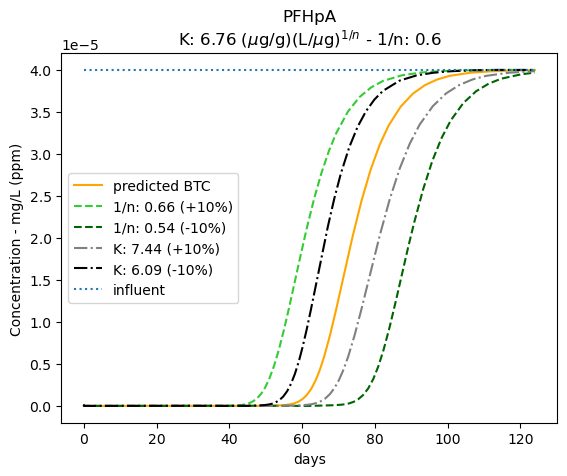

In [4]:
for comp in compounds:
    print(comp)
    
    # SETTING UP PSDM simulation column
    column = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,\
                   optimize=False
                   )

    print('EBCT: ', np.round(column.ebct, 2), ' min') 
    column.test_range = np.array([k_data[comp]['K']]) 
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    # only results is used in this example
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    column2 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data2,\
                   optimize=False
                   )

    column2.test_range = np.array([k_data2[comp]['K']]) 
    column2.xn_range = np.array([k_data2[comp]['1/n']])        
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)
    
    column3 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data3,\
                   optimize=False
                   )

    column3.test_range = np.array([k_data3[comp]['K']]) 
    column3.xn_range = np.array([k_data3[comp]['1/n']])        
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)  
    
    column4 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data4,\
                   optimize=False
                   )

    column4.test_range = np.array([k_data4[comp]['K']]) 
    column4.xn_range = np.array([k_data4[comp]['1/n']])        
    _compound, _k, _xn, _ssqs, results4 = column4.run_psdm_kfit(comp)      
    
    column5 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data5,\
                   optimize=False
                   )

    column5.test_range = np.array([k_data5[comp]['K']]) 
    column5.xn_range = np.array([k_data5[comp]['1/n']])        
    _compound, _k, _xn, _ssqs, results5 = column5.run_psdm_kfit(comp)     
    
    ### plotting results 
    # units are converted from ug/L to mg/L 
    plt.plot(results.index, 
             results.values/1000., 
             label='predicted BTC',
             color='orange')
    plt.plot(results2.index, 
             results2.values/1000., 
             label='1/n: '+repr(round(k_data2.loc['1/n'].values[0],2))+' (+'+repr(percent_xn)+'%)',
             linestyle='dashed',
             color='limegreen')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='1/n: '+repr(round(k_data3.loc['1/n'].values[0],2))+' (-'+repr(percent_xn)+'%)',
             linestyle='dashed',
             color='darkgreen')
    plt.plot(results4.index, 
             results4.values/1000., 
             label='K: '+repr(round(k_data4.loc['K'].values[0],2))+' (+'+repr(percent_K)+'%)',
             linestyle='dashdot',
             color='gray')
    plt.plot(results5.index, 
             results5.values/1000., 
             label='K: '+repr(round(k_data5.loc['K'].values[0],2))+' (-'+repr(percent_K)+'%)',
             linestyle='dashdot',
             color='black')    
    (raw_data[column2.influent][comp]/1000.).plot.line(label='influent',linestyle=':')    
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(k_data.loc['K'].values[0],2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(k_data.loc['1/n'].values[0],3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example1.png', dpi=300)
    
    
    tab2 = 'model-'+comp
    ## Set up file to write output
    with pd.ExcelWriter('Example_TCE_' + carbons[0] + '_example1.xlsx') as writer:
        results.to_excel(writer, sheet_name=tab2)

In [5]:
column.psdm_Ds

PFHpA    9.253253e-10
dtype: float64

In [6]:
column.__dict__

{'psdm_teller': 1,
 'psdm_Ds': PFHpA    9.253253e-10
 dtype: float64,
 'project_name': 'PSDM',
 'nc': 8,
 'mc': 12,
 'nz': 12,
 'ne': 1,
 'wr': array([0.00672384, 0.02451753, 0.04701138, 0.06589205, 0.07358414,
        0.06571099, 0.04254046, 0.00735294]),
 'az': array([[-111.        ,  123.32567903,  -16.15300443,    5.62792783,
           -2.87430718,    1.82689987,   -1.35343032,    1.13618035,
           -1.07434175,    1.1686638 ,   -1.63026721,    1.        ],
        [ -47.63681894,   37.81715275,   12.44590988,   -3.80770135,
            1.87263551,   -1.17133779,    0.86071237,   -0.71923468,
            0.67824687,   -0.73663641,    1.02679258,   -0.62972079],
        [  13.60025147,  -27.12882855,    6.87471114,    8.91747808,
           -3.4618661 ,    1.99217543,   -1.40716158,    1.15088501,
           -1.07192793,    1.15598468,   -1.60567472,    0.98397308],
        [  -6.91528939,   12.11254714,  -13.01398383,    2.52379732,
            7.33810751,   -3.24881605,    2.

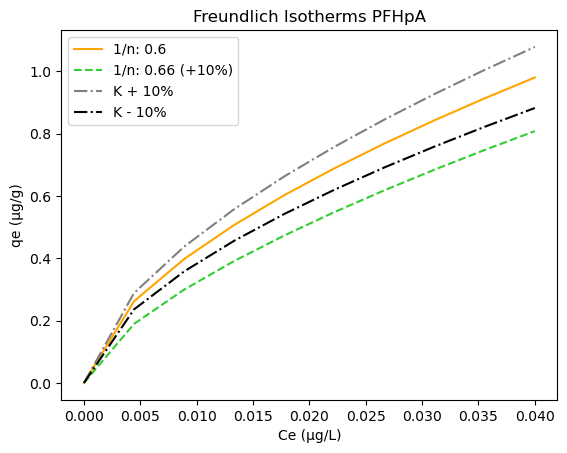

In [7]:
# Given Freundlich parameters
K = k_data.loc['K'].values[0]
xn = k_data.loc['1/n'].values[0]
xn2 = k_data2.loc['1/n'].values[0]
K3  = k_data4.loc['K'].values[0]
K4  = k_data5.loc['K'].values[0]

#//Mathieu: important to adjust range of Ce
Ce_range = np.linspace(0, 0.04, 10) #//Mathieu: results.values gives conc of 4*10^-2 µg/L so <1

# Calculate q values using Freundlich isotherm equation
q1 = K * Ce_range ** (xn)
q2 = K * Ce_range ** (xn2)
q3 = K3 * Ce_range ** (xn)
q4 = K4 * Ce_range ** (xn)

# Plot the isotherm curve
plt.plot(Ce_range, q1, label='1/n: '+repr(round(xn,2)),color='orange')
plt.plot(Ce_range, q2, label='1/n: '+repr(round(xn2,2))+' (+'+repr(percent_xn)+'%)',linestyle='dashed',color='limegreen')
plt.plot(Ce_range, q3, label='K + '+repr(percent_K)+'%',linestyle='dashdot',color='gray')
plt.plot(Ce_range, q4, label='K - '+repr(percent_K)+'%',linestyle='dashdot',color='black')
plt.xlabel('Ce (µg/L)')
plt.ylabel('qe (µg/g)')
plt.title('Freundlich Isotherms '+comp)
plt.legend()
plt.grid(False)
plt.show()

## TCE

In [8]:
fn = '6.3_Input_TCE.xlsx'

chem_data = PSDM.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data

raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

In [9]:
#//Mathieu:
percent_xn = 10
percent_K = 10

#//Mathieu: make copies of isotherm data:

k_data2 = k_data.copy()
k_data2.loc['1/n'] = k_data.loc['1/n']*(1+(percent_xn/100))
k_data3 = k_data.copy()
k_data3.loc['1/n'] = k_data.loc['1/n']*(1-(percent_xn/100))
k_data4 = k_data.copy()
k_data4.loc['K'] = k_data.loc['K']*(1+(percent_K/100))
k_data5 = k_data.copy()
k_data5.loc['K'] = k_data.loc['K']*(1-(percent_K/100))

print(k_data)


      Trichloroethylene
K               5026.04
1/n                0.43
q                  1.00
brk              200.00
AveC           50000.00


Trichloroethylene
EBCT:  9.4  min


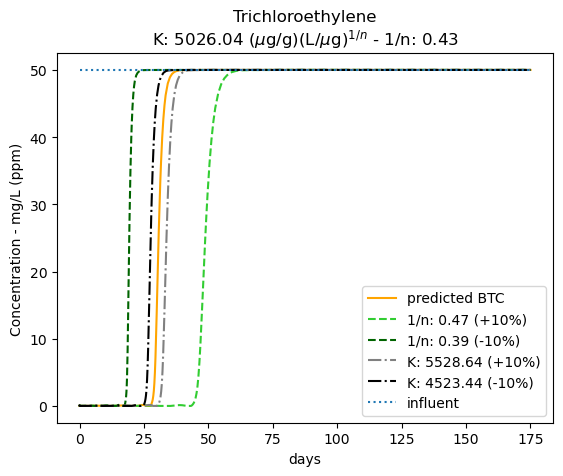

In [10]:
for comp in compounds:
    print(comp)
    
    # SETTING UP PSDM simulation column
    column = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,\
                   optimize=False
                   )

    print('EBCT: ', np.round(column.ebct, 2), ' min') 
    column.test_range = np.array([k_data[comp]['K']]) 
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    # only results is used in this example
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    column2 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data2,\
                   optimize=False
                   )

    column2.test_range = np.array([k_data2[comp]['K']]) 
    column2.xn_range = np.array([k_data2[comp]['1/n']])        
    _compound, _k, _xn, _ssqs, results2 = column2.run_psdm_kfit(comp)
    
    column3 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data3,\
                   optimize=False
                   )

    column3.test_range = np.array([k_data3[comp]['K']]) 
    column3.xn_range = np.array([k_data3[comp]['1/n']])        
    _compound, _k, _xn, _ssqs, results3 = column3.run_psdm_kfit(comp)  
    
    column4 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data4,\
                   optimize=False
                   )

    column4.test_range = np.array([k_data4[comp]['K']]) 
    column4.xn_range = np.array([k_data4[comp]['1/n']])        
    _compound, _k, _xn, _ssqs, results4 = column4.run_psdm_kfit(comp)      
    
    column5 = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data5,\
                   optimize=False
                   )

    column5.test_range = np.array([k_data5[comp]['K']]) 
    column5.xn_range = np.array([k_data5[comp]['1/n']])        
    _compound, _k, _xn, _ssqs, results5 = column5.run_psdm_kfit(comp)     
    
    ### plotting results 
    # units are converted from ug/L to mg/L 
    plt.plot(results.index, 
             results.values/1000., 
             label='predicted BTC',
             color='orange')
    plt.plot(results2.index, 
             results2.values/1000., 
             label='1/n: '+repr(round(k_data2.loc['1/n'].values[0],2))+' (+'+repr(percent_xn)+'%)',
             linestyle='dashed',
             color='limegreen')
    plt.plot(results3.index, 
             results3.values/1000., 
             label='1/n: '+repr(round(k_data3.loc['1/n'].values[0],2))+' (-'+repr(percent_xn)+'%)',
             linestyle='dashed',
             color='darkgreen')
    plt.plot(results4.index, 
             results4.values/1000., 
             label='K: '+repr(round(k_data4.loc['K'].values[0],2))+' (+'+repr(percent_K)+'%)',
             linestyle='dashdot',
             color='gray')
    plt.plot(results5.index, 
             results5.values/1000., 
             label='K: '+repr(round(k_data5.loc['K'].values[0],2))+' (-'+repr(percent_K)+'%)',
             linestyle='dashdot',
             color='black')    
    (raw_data[column2.influent][comp]/1000.).plot.line(label='influent',linestyle=':')    
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(k_data.loc['K'].values[0],2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(k_data.loc['1/n'].values[0],3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example1.png', dpi=300)
    
    
    tab2 = 'model-'+comp
    ## Set up file to write output
    with pd.ExcelWriter('Example_TCE_' + carbons[0] + '_example1.xlsx') as writer:
        results.to_excel(writer, sheet_name=tab2)

In [11]:
column.psdm_Ds

Trichloroethylene    3.229310e-09
dtype: float64

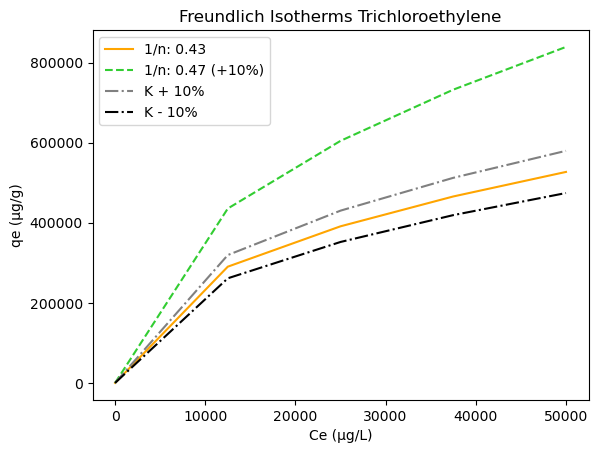

In [12]:
# Given Freundlich parameters
K = k_data.loc['K'].values[0]
xn = k_data.loc['1/n'].values[0]
xn2 = k_data2.loc['1/n'].values[0]
K4  = k_data4.loc['K'].values[0]
K5  = k_data5.loc['K'].values[0]

#//Mathieu: important to adjust range of Ce
Ce_range = np.linspace(0, 50000, 5)

# Calculate q values using Freundlich isotherm equation
q1 = K * Ce_range ** (xn)
q2 = K * Ce_range ** (xn2)
q3 = K4 * Ce_range ** (xn)
q4 = K5 * Ce_range ** (xn)

# Plot the isotherm curve
plt.plot(Ce_range, q1, label='1/n: '+repr(round(xn,2)),color='orange')
plt.plot(Ce_range, q2, label='1/n: '+repr(round(xn2,2))+' (+'+repr(percent_xn)+'%)',linestyle='dashed',color='limegreen')
plt.plot(Ce_range, q3, label='K + '+repr(percent_K)+'%',linestyle='dashdot',color='gray')
plt.plot(Ce_range, q4, label='K - '+repr(percent_K)+'%',linestyle='dashdot',color='black')
plt.xlabel('Ce (µg/L)')
plt.ylabel('qe (µg/g)')
plt.title('Freundlich Isotherms '+comp)
plt.legend()
plt.grid(False)
plt.show()

## Reference: Monte Carlo approach to calculating uncertainty using Python

Reference: https://medium.com/@ch.thombson18/monte-carlo-approach-to-calculating-uncertainty-using-python-7d4298a307a8

Value of area without noise: 10800
Average value of area: 10806.687470120196
Systematic error due to nonlinearity: 6.68747012019594
Standard deviation: 107.9773860574527


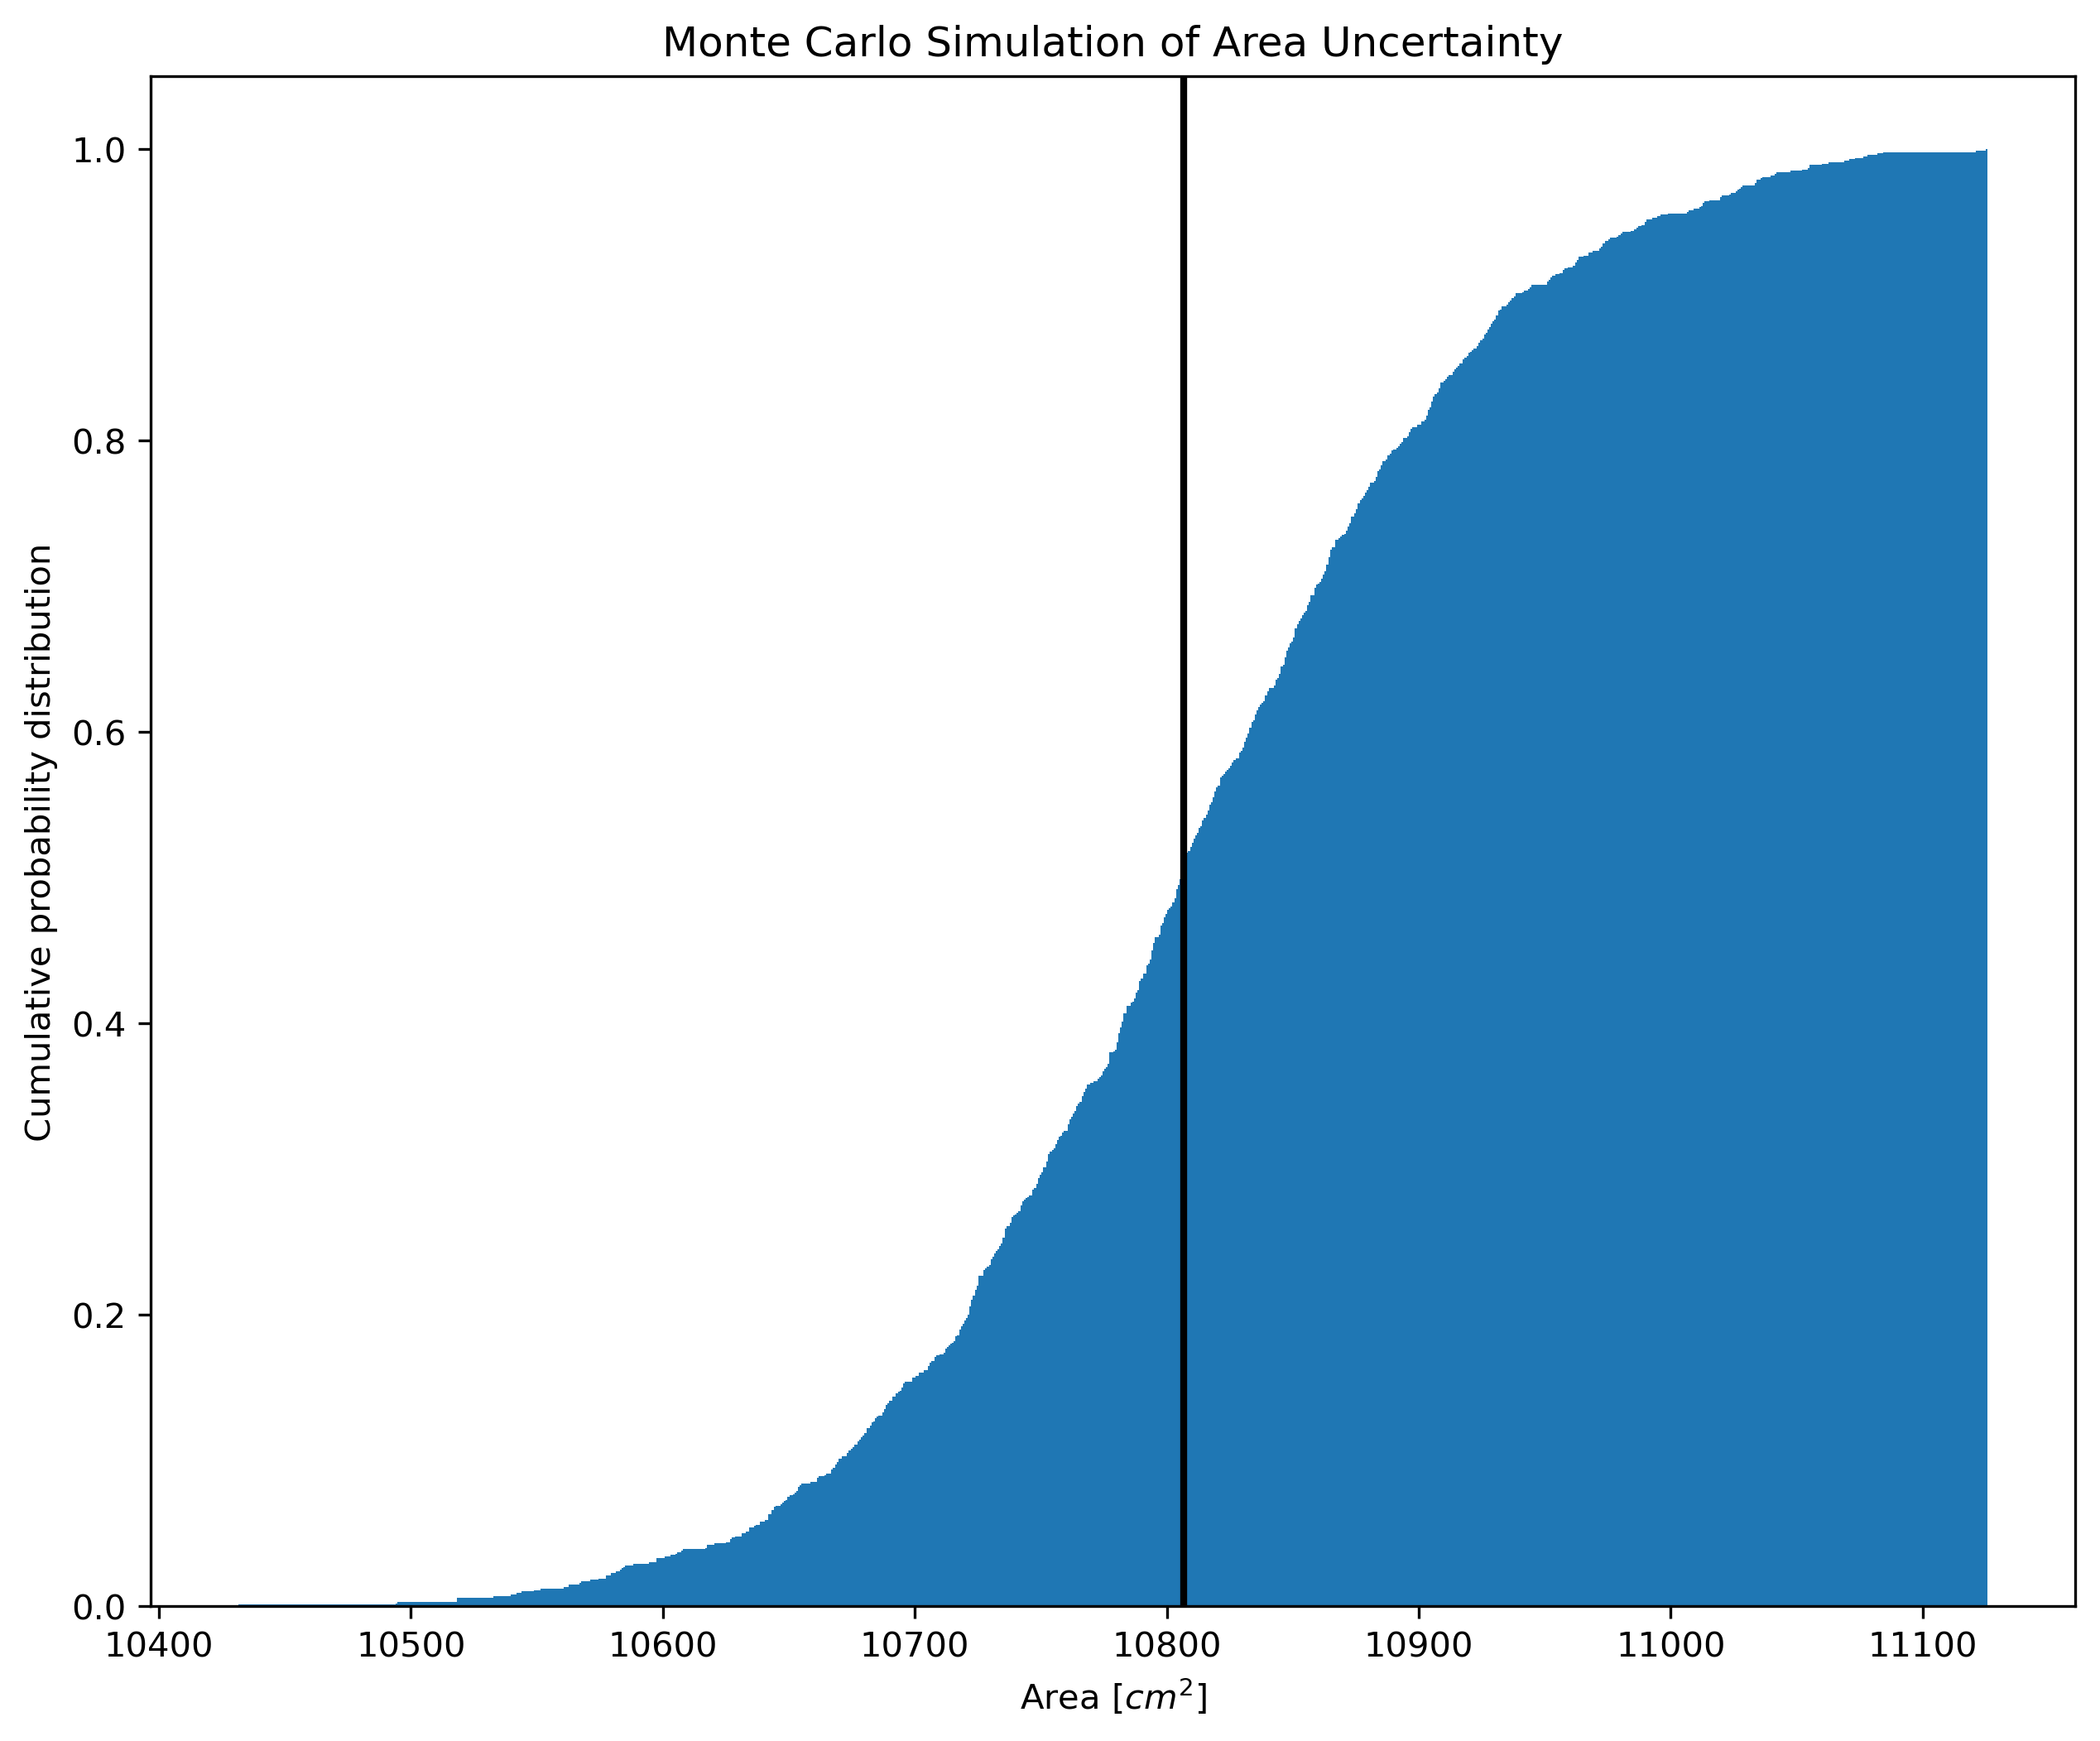

In [13]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def area (length,breadth): #define area of the table
    A = length*breadth
    return A

n = 1000 #Number of random samples
l0 = 120; l = np.random.normal (l0, 0.5, n) #Here, in np.random.normal (mean, standard_deviation, number of samples)
b0 = 90; b = np.random.normal (b0, 0.8, n)

A = area (l,b) #array of area values

print ("Value of area without noise:", area (l0,b0))
print ("Average value of area:", A.mean())
print ("Systematic error due to nonlinearity:", A.mean()-area(l0,b0)) #Systematic error=mean-value without noise.
print ("Standard deviation:", A.std()) #Uncertainty in the measurement of area.

#Plotting Cumulative Probability Distribution 
fig, ax= plt.subplots(figsize=(10, 8))
plt.hist (A, cumulative=True, bins = 1000, density=True) #Density parameter is set to True to normalised the y-axis scale
plt.axvline(x=A.mean(), color = 'k', linestyle='solid', linewidth = 2)
ax.set_title("Monte Carlo Simulation of Area Uncertainty")
plt.xlabel ('Area [$cm^2$]')
plt.ylabel ('Cumulative probability distribution')
fig.set_dpi(300.0)
plt.show()